In [4]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime
import math
from collections import defaultdict

In [5]:
tracking_w1_data_original = pd.read_csv('../NFLData/week1.csv')
tracking_w2_data_original = pd.read_csv('../NFLData/week2.csv')
tracking_w3_data_original = pd.read_csv('../NFLData/week3.csv')
tracking_w4_data_original = pd.read_csv('../NFLData/week4.csv')
tracking_w5_data_original = pd.read_csv('../NFLData/week5.csv')
tracking_w6_data_original = pd.read_csv('../NFLData/week6.csv')
tracking_w7_data_original = pd.read_csv('../NFLData/week7.csv')
tracking_w8_data_original = pd.read_csv('../NFLData/week8.csv')
tracking_data = pd.concat([tracking_w1_data_original,tracking_w2_data_original,tracking_w3_data_original,tracking_w4_data_original,tracking_w5_data_original,tracking_w6_data_original,tracking_w7_data_original,tracking_w8_data_original])

In [6]:
tracking_data= tracking_data.dropna()

In [7]:
tracking_copy = tracking_data.copy()
#tracking_copy = tracking_copy.merge(player_positions,how="inner",on="nflId")
categorical_data = ["playDirection","event","officialPosition"]
category_codes = {}

for i in tracking_data:
    if i in categorical_data:
        specific_codes = {}
        tracking_data[i] = tracking_data[i].astype("category")
        tracking_data[i] = tracking_data[i].cat.codes
        coded = tracking_data[i].unique()#
        count = 0
        for j in tracking_copy[i].unique():
           specific_codes[j] = coded[count]
           count += 1
        category_codes[i] = specific_codes
for i in category_codes:
  print("{} -".format(i))
  for j in category_codes[i]:
    print("{}: {}".format(j, category_codes[i][j]))

playDirection -
right: 1
left: 0
event -
None: 0
ball_snap: 4
autoevent_passforward: 2
pass_forward: 16
autoevent_ballsnap: 1
line_set: 12
play_action: 21
pass_arrived: 15
autoevent_passinterrupted: 3
fumble: 7
fumble_offense_recovered: 8
qb_sack: 22
run: 24
man_in_motion: 13
pass_outcome_caught: 17
pass_outcome_incomplete: 18
pass_tipped: 19
qb_strip_sack: 23
shift: 25
first_contact: 6
huddle_break_offense: 10
lateral: 11
handoff: 9
penalty_flag: 20
tackle: 26
dropped_pass: 5
out_of_bounds: 14


In [8]:
event_dict = category_codes['event']
terminal_events = ['qb_sack','pass_outcome_incomplete','qb_strip_sack','pass_outcome_caught','pass_tipped','fumble','fumble_offense_recovered','lateral','run','pass_arrived']
terminal_events = [event_dict[x] for x in terminal_events]

In [9]:
def generate_sequences(df):
    sequence_dict_dense = defaultdict(dict)
    current_seq_dense = []
    gameID = -1
    playID = -1
    nflID = -1
    team = -1
    collect = False
    terminal = False
    for row in df.itertuples():
        if not(collect):
            collect = (row.event == 4)
        if not(terminal):
            terminal= (row.event in terminal_events)    # Play terminal or changes from coached D to responsive D
        if (gameID == -1 or playID == -1 or nflID == -1) or (gameID != row.gameId or playID != row.playId or nflID != row.nflId):
            #print(current_seq_dense)
            if len(current_seq_dense) > 10:
                sequence_dict_dense[(gameID,playID,team)][nflID] = current_seq_dense
                current_seq_dense = []
                
            terminal = (row.event in terminal_events)
            collect = (row.event == 4)
            gameID = row.gameId
            playID = row.playId
            nflID = row.nflId
            team = row.team
            if collect and len(current_seq_dense) < 90 and not(terminal):
                current_seq_dense.append([row.x,row.y]) 

        elif gameID == row.gameId and playID == row.playId and nflID == row.nflId and collect and not(terminal):
            current_seq_dense.append([row.x,row.y]) 
    return sequence_dict_dense

In [10]:
trajectory_dict = generate_sequences(tracking_data)

In [11]:
print(f"Sequences Generated for {len(trajectory_dict)//2} plays")

Sequences Generated for 8532 plays


In [12]:
trajectory_dict_keys = list(trajectory_dict.keys())
print(trajectory_dict_keys[:5])

[(2021090900, 97, 'TB'), (2021090900, 97, 'DAL'), (2021090900, 137, 'TB'), (2021090900, 137, 'DAL'), (2021090900, 187, 'TB')]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2021090900, 97, 'DAL')



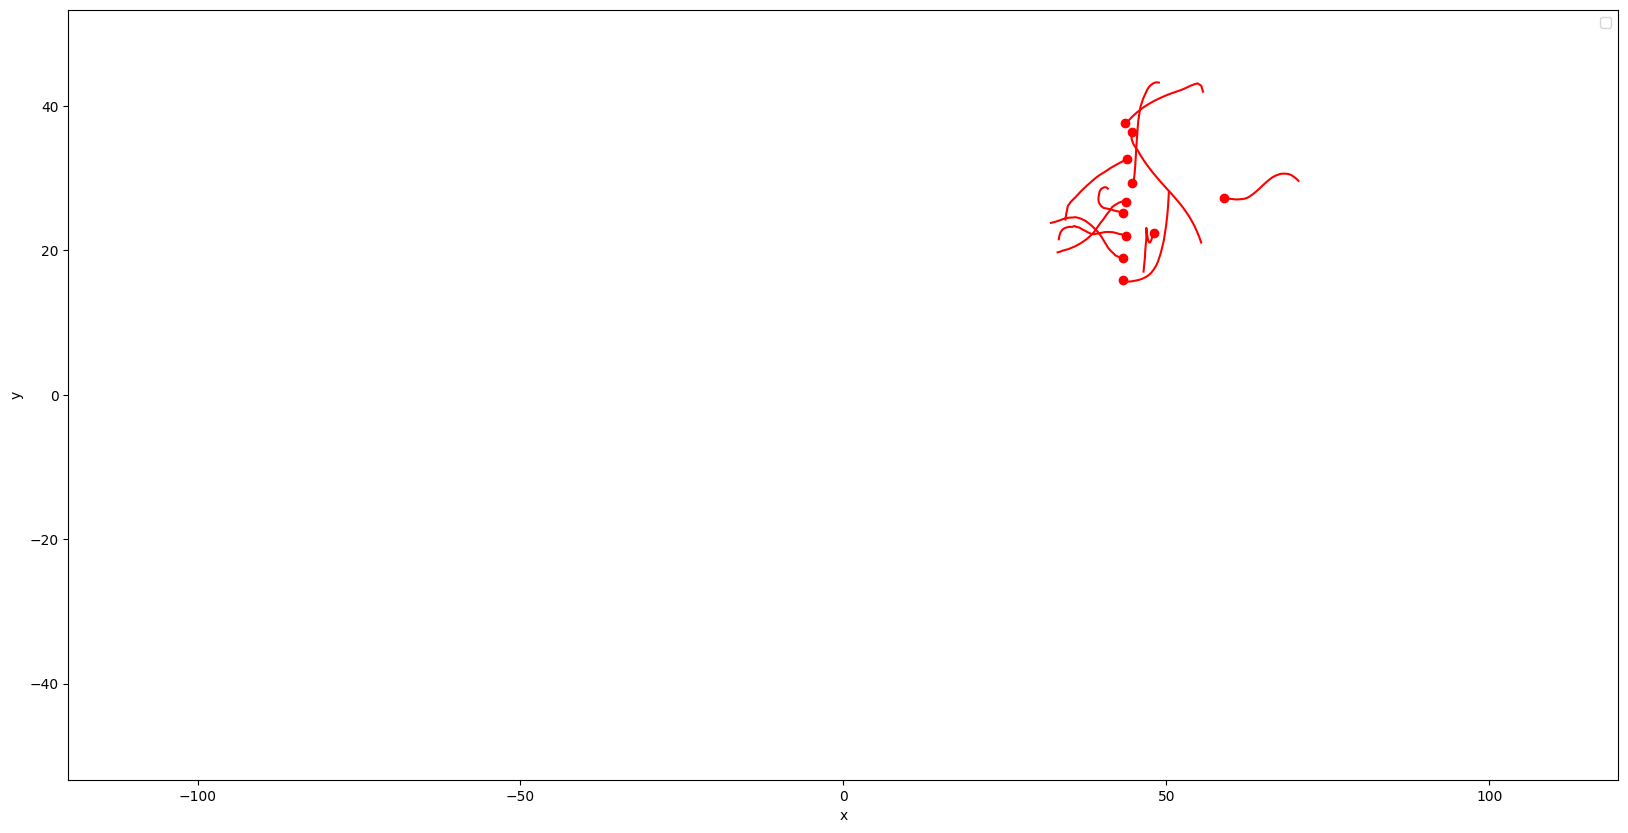

In [15]:
index = int(input("Enter an integer to select a play from the available dictionary: "))
play_key = trajectory_dict_keys[index]

print(play_key,end="\n\n")

play = trajectory_dict[play_key]
play_seq_list = list(play.values())
figure = plt.figure(figsize=(20,10))

for seq in play_seq_list:
    x = [x[0] for x in seq]
    y = [x[1] for x in seq]


    plt.scatter(x[0],y[0],color="r")
    plt.plot(x,y,color = "r")

plt.ylim([-53.3, 53.3])
plt.xlim([-120, 120])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [18]:
trajectory_dict_keys_df = pd.DataFrame(trajectory_dict_keys,columns=['gameId','playId','team'])
print(trajectory_dict_keys_df.head(5))
print(trajectory_dict_keys_df.shape[0])

       gameId  playId team
0  2021090900      97   TB
1  2021090900      97  DAL
2  2021090900     137   TB
3  2021090900     137  DAL
4  2021090900     187   TB
17064


In [19]:
trajectory_dict_keys_df.to_csv('trajectory_dict_keys.csv', index=False)


In [20]:
import json

trajectory_dict_upload = {str(key): value for key, value in trajectory_dict.items()}

with open('all_trajectory_dict.json', 'w') as f:
    json.dump(trajectory_dict_upload, f)